In [1]:
import kaggle
import h5py
from imutils import paths
import pandas as pd
import numpy as np
import re
import random
import cv2
from keras.preprocessing.image import img_to_array
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation
from keras.layers.core import Flatten
from keras.layers.core import Dropout
from keras.layers.core import Dense
from keras import backend as K
from numpy.random import seed
from tensorflow.random import set_seed
from keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import matplotlib.pyplot as plt
from keras.models import load_model
from keras.models import model_from_json

In [2]:
# download specified dataset
!kaggle datasets download -d nih-chest-xrays/sample --unzip


  0%|          | 0.00/4.20G [00:00<?, ?B/s]
  0%|          | 2.00M/4.20G [00:00<03:44, 20.1MB/s]
  0%|          | 5.00M/4.20G [00:00<05:14, 14.3MB/s]
  0%|          | 8.00M/4.20G [00:00<04:31, 16.5MB/s]
  0%|          | 10.0M/4.20G [00:01<11:04, 6.77MB/s]
  0%|          | 13.0M/4.20G [00:01<08:37, 8.68MB/s]
  0%|          | 16.0M/4.20G [00:01<06:53, 10.9MB/s]
  0%|          | 18.0M/4.20G [00:01<06:26, 11.6MB/s]
  0%|          | 21.0M/4.20G [00:01<05:21, 14.0MB/s]
  1%|          | 24.0M/4.20G [00:01<04:36, 16.2MB/s]
  1%|          | 27.0M/4.20G [00:02<04:05, 18.2MB/s]
  1%|          | 30.0M/4.20G [00:02<04:01, 18.5MB/s]
  1%|          | 33.0M/4.20G [00:02<03:41, 20.2MB/s]
  1%|          | 36.0M/4.20G [00:02<03:27, 21.5MB/s]
  1%|          | 39.0M/4.20G [00:02<03:16, 22.8MB/s]
  1%|          | 42.0M/4.20G [00:02<03:09, 23.6MB/s]
  1%|1         | 45.0M/4.20G [00:02<03:03, 24.3MB/s]
  1%|1         | 48.0M/4.20G [00:02<03:00, 24.7MB/s]
  1%|1         | 51.0M/4.20G [00:03<03:02, 24.3MB/s]
 

In [42]:
def data_fetch(): 
    labels = pd.read_csv('sample_labels.csv')
    labels=labels[["Image Index", "Finding Labels"]]
    labels.columns=["image", "labels"]
    # ensuring the index is using the file name
    labels["image"]=labels.image.str[:-4]
    labels.set_index("image", inplace=True);
    # splitting the multiple labels
    dummies=labels.labels.str.split("|", expand=True)
    dummies=dummies.stack().str.get_dummies().sum(level=0)
    labels=labels.join(dummies)
    labels=labels[['No Finding', 'Effusion', 'Infiltration', 'Atelectasis', 'Edema', 'Consolidation', 'Mass', 'Nodule','Fibrosis']]
    labels.columns=['No_Finding', 'Effusion', 'Infiltration', 'Atelectasis', 'Edema', 'Consolidation', 'Mass', 'Nodule','Fibrosis']
    return labels

In [43]:
def save_data(X_train, X_test, y_train, y_test, file):
    # saving processed file
    hf = h5py.File("./saves/"+file+'.h5', 'w')
    hf.create_dataset('X_train', data=X_train)
    hf.create_dataset('y_train', data=y_train)
    hf.create_dataset('X_test', data=X_test)
    hf.create_dataset('y_test', data=y_test)
    hf.close()

In [44]:
def data_process(IMAGE_DIMS=(128,128,3)):
    labels=data_fetch()
    dataset="./sample/images"
    
    # initialize the data and labels
    X = []
    y = []
    # randomize the images
    imagePaths = sorted(list(paths.list_images(dataset)))
    random.seed(17)
    random.shuffle(imagePaths)
    for imagePath in imagePaths:
        # load the image, pre-process it, and store it in the data list
        image = cv2.imread(imagePath)
        ##
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        ##
        image = cv2.resize(image, (IMAGE_DIMS[1], IMAGE_DIMS[0]), interpolation=cv2.INTER_CUBIC)
        image = img_to_array(image)
        X.append(image)
        
        n= re.findall(r"\d{8}_\d{3}", imagePath) 
        l = labels.loc[n].to_numpy()
        y.append(l)
    X = np.array(X, dtype="float") / 255.0
    y = np.vstack(y)
    (X_train, X_test, y_train, y_test) = train_test_split(X, y, test_size=0.2, random_state=17)
    #save_data(X_train, X_test, y_train, y_test, "data")
    return X_train, X_test, y_train, y_test

In [2]:
def load_data(file):
   # reading processed file
    hf = h5py.File("./saves/"+file+".h5", 'r')
    X_train = hf.get('X_train')
    X_train = np.array(X_train)
    y_train = hf.get('y_train')
    y_train = np.array(y_train)
    X_test = hf.get('X_test')
    X_test = np.array(X_test)
    y_test = hf.get('y_test')
    y_test = np.array(y_test)
    hf.close()
    return X_train, X_test, y_train, y_test
#(X_train, X_test, y_train, y_test) = load_data("data")

In [37]:
IMAGE_DIMS = (128, 128, 3)
(X_train, X_test, y_train, y_test) = data_process(IMAGE_DIMS)

In [3]:
def data_aug(X_train=X_train):
    # construct the image generator for data augmentation
    datagen = ImageDataGenerator(featurewise_center=False,  # set input mean to 0 over the dataset
            samplewise_center=True,  # set each sample mean to 0
            featurewise_std_normalization=False,  # divide inputs by std of the dataset
            samplewise_std_normalization=False,  # divide each input by its std
            zca_whitening=False,  # apply ZCA whitening
            rotation_range=40,  # randomly rotate images in the range (degrees, 0 to 180)
            width_shift_range=0.4,  # randomly shift images horizontally (fraction of total width)
            height_shift_range=0.4,  # randomly shift images vertically (fraction of total height)
            horizontal_flip=True,  # randomly flip images
            vertical_flip=False)  # randomly flip images
    datagen.fit(X_train)
    return datagen

In [4]:
datagen=data_aug(X_train)

In [5]:
# Helper Functions  Learning Curves and Confusion Matrix

from keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

class MetricsCheckpoint(Callback):
    """Callback that saves metrics after each epoch"""
    def __init__(self, savepath):
        super(MetricsCheckpoint, self).__init__()
        self.savepath = savepath
        self.history = {}
    def on_epoch_end(self, epoch, logs=None):
        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
        np.save(self.savepath, self.history)


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize = (5,5))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    

def plot_learning(history):
    plt.style.use('seaborn-whitegrid')
    sns.set(style="white", font_scale = 1.5)
    fig, axes = plt.subplots(1,2, figsize=(20,5), sharex=True)
    axes[0].set_title('Loss')
    axes[0].plot(history.history['loss'], label='train', )
    axes[0].plot(history.history['val_loss'], label='test')
    axes[0].legend()
    #plot accuracy during training
    axes[1].set_title('Accuracy')
    axes[1].plot(history.history['accuracy'], label='train')
    axes[1].plot(history.history['val_accuracy'], label='test')
    axes[1].legend()
    plt.savefig('./saves/training curve.png')
    plt.show()
    return

In [53]:
def build_model(IMAGE_DIMS, epochs=10, BS=32):
    model = build(width=IMAGE_DIMS[1], height=IMAGE_DIMS[0], depth=IMAGE_DIMS[2], classes=9, finalAct="sigmoid")
    # compile the model using binary cross-entropy
    opt=Adam(lr=1e-3, decay=1e-3 / epochs)
    model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])
    # valdation_data=(X_test, y_test)
    history = model.fit(datagen.flow(X_train, y_train, batch_size=BS), validation_split=0.2, steps_per_epoch=len(X_train) // BS, epochs=epochs, verbose=1, callbacks = [MetricsCheckpoint('logs')], use_multiprocessing=True, workers = 4)
    return model, history

In [48]:
def save_model(model, history, saved_model="model.h5", saved_weight="weights.h5"):   
    model.save("./saves/"+saved_model+'.h5')  # creates a HDF5 file 'my_model.h5'
    model.save_weights("./saves/"+saved_weight+'.h5')  # to store

In [47]:
def load_model(saved_model, saved_weight):
    model = load_model("./saves/"+saved_model+'.h5')
    model.load_weights("./saves/"+saved_weight+'.h5')
    return model

In [20]:
def build(width, height, depth, classes, finalAct="softmax"):
    # initialize the model along with the input shape to be
    # "channels last" and the channels dimension itself
    seed(17)
    set_seed(17)
    K.clear_session()
    model = Sequential()
    inputShape = [height, width, depth]

    model.add(Conv2D(32, (3, 3), padding="same", activation="relu", input_shape=inputShape))
    model.add(Conv2D(32, (3, 3), padding = 'Same', activation ='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))

    model.add(Conv2D(128, (3, 3), padding="same", activation="relu"))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    
    model.add(Conv2D(64, (3, 3), padding="same", activation="relu"))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    
    model.add(Flatten())
    model.add(Dense(512, activation="relu"))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))

    # softmax classifier
    model.add(Dense(classes, activation=finalAct))

    # plot the model architecture in shell
    model.summary()
    # return the constructed network architecture
    return model


In [40]:
IMAGE_DIMS = (128, 128, 1)
(model,history)=build_model(IMAGE_DIMS, 7, BS=64)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 128, 32)      320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 32)      9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 32)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 64, 64, 32)        128       
_________________________________________________________________
dropout (Dropout)            (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 128)       36992     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 64, 64, 128)       1

In [31]:
save_model(model,history, "model2", "weight2")

In [27]:
test = load_model('test_model')
test.load_weights('test_weights')
#test.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])
test.evaluate(X_test,y_test, verbose=0) 

[0.31090548634529114, 0.614973247051239]

In [74]:
def base_build(width, height, depth, classes, finalAct="softmax"):
    # initialize the model along with the input shape to be
    # "channels last" and the channels dimension itself
    seed(17)
    set_seed(17)
    K.clear_session()
    model = Sequential()
    inputShape = [height, width, depth]

    model.add(Conv2D(32, (3, 3), padding="same", activation="relu", input_shape=inputShape))
    model.add(Conv2D(32, (3,3), padding = 'Same', activation ='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))

    model.add(Conv2D(128, (3, 3), padding="same", activation="relu"))
    model.add(Conv2D(128, (3, 3), padding="same", activation="relu"))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    
    model.add(Conv2D(64, (3, 3), padding="same", activation="relu"))
    model.add(Conv2D(64, (3, 3), padding="same", activation="relu"))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))

    # first (and only) set of FC => RELU layers
    model.add(Flatten())
    model.add(Dense(512, activation="relu"))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))

    # softmax classifier
    model.add(Dense(classes, activation=finalAct))

    # plot the model architecture in shell
    model.summary()
    # return the constructed network architecture
    return model


In [12]:
model = build(width=IMAGE_DIMS[1], height=IMAGE_DIMS[0], depth=IMAGE_DIMS[2], classes=9, finalAct="sigmoid")

# initialize the optimizer (SGD is sufficient)
EPOCHS = 10
INIT_LR = 1e-3
BS = 32
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)

# compile the model using binary cross-entropy
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])

history = model.fit(datagen.flow(X_train, y_train, batch_size=BS), validation_data=(X_test, y_test), steps_per_epoch=len(X_train) // BS, epochs=EPOCHS, verbose=1, callbacks = [MetricsCheckpoint('logs')])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 128, 32)      896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 32)      9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 32)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 64, 64, 32)        128       
_________________________________________________________________
dropout (Dropout)            (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 128)       36992     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 64, 64, 128)       1

Saved model to disk


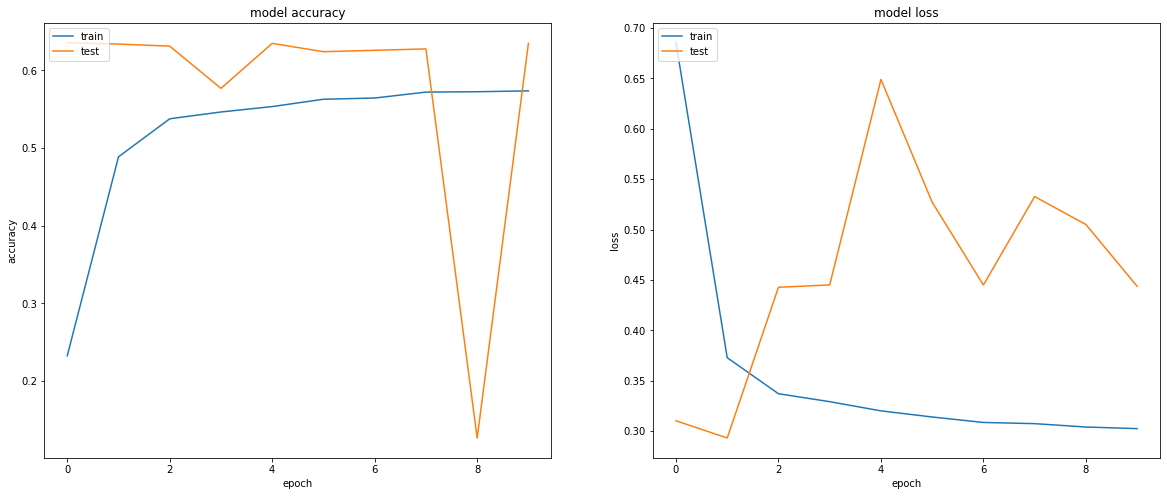


 CNN #2B - accuracy: 0.6345810890197754 



In [24]:
score = model.evaluate(X_test,y_test, verbose=0) 
plot_learning(history)
plt.show()
print('\n CNN #2B - accuracy:', score[1],'\n')
y_pred = model.predict(X_test)

In [30]:
y_pred[0]

array([7.5676286e-01, 1.1782974e-02, 5.6997776e-02, 2.0665526e-03,
       8.1881311e-08, 1.9118190e-04, 2.8768182e-04, 7.6913834e-04,
       6.8870868e-06], dtype=float32)

In [27]:
# loading the model from file
loaded_model = load_model()
loaded_model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])
loaded_model.evaluate(X_test,y_test, verbose=0) 

[0.4436507225036621, 0.6345810890197754]

In [80]:
# to predict assuming the file path to the image.png is "img"

def predict_pathogen(img, loaded_model):
    image = cv2.imread(img)
    image = cv2.resize(image, (128, 128), interpolation=cv2.INTER_CUBIC)
    image = img_to_array(image)
    image = np.array(image, dtype="float") / 255.0
    image = np.expand_dims(image, axis=0)
    outcome = loaded_model.predict(image)
    print(outcome)
    return outcome

In [81]:
pathogen = predict_pathogen("./image.png", loaded_model)

[[7.00825691e-01 1.75554454e-02 1.16868466e-01 4.92846966e-03
  2.23756729e-06 7.94202089e-04 8.43316317e-04 3.23116779e-03
  1.20314420e-04]]


In [91]:
last_conv_layer = model.get_layer('block5_conv3')

AttributeError: 'Sequential' object has no attribute 'layers_by_depth'

In [92]:
model.get_layer

<bound method Model.get_layer of <tensorflow.python.keras.engine.sequential.Sequential object at 0x0000027DDCF918B0>>

In [6]:
from keras.layers import Input
from keras.applications.densenet import DenseNet121
from keras.models import Model

In [7]:
def dense_build(IMAGE_DIMS, classes, finalAct="softmax"):
    # initialize the model along with the input shape to be
    # "channels last" and the channels dimension itself
    seed(17)
    set_seed(17)
    K.clear_session()
    img_in=Input(IMAGE_DIMS)
    model = DenseNet121(include_top= False , # remove  the 3 fully-connected layers at the top of the network
                weights='imagenet',      # pre train weight 
                input_tensor= img_in, 
                input_shape= IMAGE_DIMS,
                pooling ='avg')
    # plot the model architecture in shell
    model.summary()
    # return the constructed network archiecture
    x = model.output  
    predictions = Dense(classes, activation=finalAct, name="predictions")(x)    # fuly connected layer for predict class 
    model = Model(inputs=img_in, outputs=predictions)
    return model

In [11]:
def build_dense_model(IMAGE_DIMS, epochs=10, BS=32):
    model = dense_build(IMAGE_DIMS, 9, finalAct="sigmoid")
    # compile the model using binary cross-entropy
    opt=Adam(lr=1e-3)#, decay=1e-3 / epochs)
    model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])
    # valdation_data=(X_test, y_test)
    history = model.fit(datagen.flow(X_train, y_train, batch_size=BS), validation_data=(X_test, y_test), verbose=1, callbacks = [MetricsCheckpoint('logs')])
    return model, history

In [12]:
(model, history) = build_dense_model(X_train.shape[1:])

Model: "densenet121"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 134, 134, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 64, 64, 64)   9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 64, 64, 64)   256         conv1/conv[0][0]                 
________________________________________________________________________________________

(4484, 128, 128, 3)

In [82]:
pip freeze > requirements.txt

Note: you may need to restart the kernel to use updated packages.


In [83]:
from matplotlib.patheffects import Stroke, Normal
def draw_outline(o, lw):
    o.set_path_effects([matplotlib.patheffects.Stroke(
        linewidth=lw, foreground='black'), matplotlib.patheffects.Normal()])

def draw_rect(ax, b, color='white'):
    patch = ax.add_patch(matplotlib.patches.Rectangle(b[:2], *b[-2:], fill=False, edgecolor=color, lw=2))
    draw_outline(patch, 4)

from PIL import Image, ImageEnhance
def increase_contrast(dx):
    image = Image.fromarray(np.uint8(dx*255))
    contrast = ImageEnhance.Contrast(image)
    contrast = contrast.enhance(2)
    dx_cont = np.array(contrast.getdata())
    return dx_cont.reshape([512,512,3])/255

In [84]:
class SaveFeatures():
    features=None
    def __init__(self, m): self.hook = m.register_forward_hook(self.hook_fn)
    def hook_fn(self, module, input, output): self.features = output
    def remove(self): self.hook.remove()

In [85]:
def create_heat_map(x):
    sfs = [SaveFeatures(l) for l in [m[-3],m[-4], m[-5], m[-6]]]
    py = m(Variable(T(x)))
    py = np.exp(to_np(py)[0])
    for o in sfs: o.remove()

    feat = np.maximum(0,to_np(sfs[1].features[0]))

    dx = data.val_ds.denorm(x)[0]
    f2=np.dot(np.rollaxis(feat,0,3), py)
    f2-=f2.min()
    f2/=f2.max()
    return dx, f2

In [88]:
x,y = X_train[500], y_train[500]
x,y = x[None], A(y)[None,None]
vx = Variable(T(x), requires_grad=True)

NameError: name 'A' is not defined